# Custom model creation with OCI and python SDK for object detection

I'm going to use python SDK to create a custom dataset of images to train a vision model. 

I'll be using a dataset to detect plastics in rivers https://huggingface.co/datasets/Kili/plastic_in_river.


Overview
- Download and prepare dataset.
- Explore the dataset
- Upload dataset to bucket.
- Create dataset in OCI
- Create vision project
- Create training model.
- Test model
- Delete OCI resources


## Download and prepare dataset
Lets import all the dependencies

In [1]:
import os
import time
import json
import oci
import mimetypes
import matplotlib.pyplot as plt
import pickle
import random
import datasets
import tqdm as notebook_tqdm
%matplotlib inline


To create a model of object detection, you do not only need to pass the label of the image but also a bounding box.

Luckily this dataset comes with both the images and the bounding boxes.


In [2]:
dataset_label = 'plastic'
data_folder = 'data'
labels = [dataset_label]

dataset_data = datasets.load_dataset("Kili/plastic_in_river")

Found cached dataset plastic_in_river (/Users/carlgira/.cache/huggingface/datasets/Kili___plastic_in_river/default/1.3.0/9f50c1fffe85018c95137b17f0e5a271be58507e17e7a3f3a4075f763c20b8de)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset contains more than 3000 images but we will only be using 100 of them. The next cell is preparing the dataset and transforming the coordenates to somthing datalabeling service could understand

In [3]:
def get_boundingbox(bbox):
    x1, y1, w, h = bbox
    x1 = x1-w/2
    y1 = y1-h/2

    cords = []
    cords.append({'x': x1 , 'y': y1 })
    cords.append({'x': x1 , 'y': y1 + h })
    cords.append({'x': x1 + w , 'y': y1 + h })
    cords.append({'x': x1 + w , 'y': y1 })

    return cords

train_data = dataset_data['train'][:100]

if not os.path.exists(data_folder):
    os.mkdir(data_folder)

for label in labels:
    if not os.path.exists('{data}/{label}'.format(data=data_folder, label=label)):
        os.mkdir('{data}/{label}'.format(data=data_folder, label=label))

    for i, img in enumerate(train_data['image']):
        file_name = "{data}/{label}/{name}.png".format(data=data_folder, label=label, name=str(i))
    
        if not os.path.exists(file_name):
            img.save(file_name)


dataset_file = '{}-dataset-bounding-box.pickle'.format(dataset_label)
dataset = {}
if os.path.exists(dataset_file):
    with open(dataset_file, 'rb') as handle:
        dataset = pickle.load(handle)
else:
    for label in labels:
        for i, bbox_list  in enumerate(train_data['litter']):
                file = "{name}.png".format(name=str(i))
                dataset[label + '/' + file] = []
                for bbox in bbox_list['bbox']:
                    dataset[label + '/' + file].append(get_boundingbox(bbox))

    with open(dataset_file, 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


We have to check that all images comply the next conditions. (for this dataset is not necessary but it's important to have in mind)

- Check that in fact are images
- Check that the content-type is correct (png, and jpeg)
- Delete those bigger than 6 MB (restriction of the dataset labeling service). 

In [4]:
count_deleted_by_size = 0
count_deleted_by_mime = 0
count_deleted_by_filter = 0
dict_dataset = []

for image in dataset.keys():
    flag_deleted = False
    content_type = None
    image_path =  data_folder + '/' + image 
    mt = mimetypes.guess_type(image_path)

    # Check that content type is correct
    if mt:
        content_type = mt[0]
        if mt[0] not in ['image/jpeg', 'image/png']:
            os.remove(image_path)
            flag_deleted = True
            count_deleted_by_filter += 1
    else:
        os.remove(image_path)
        flag_deleted = True
        count_deleted_by_mime += 1

    # Check size of image not bigger than 6MB
    if not flag_deleted and os.stat(image_path).st_size / (1024 * 1024) > 5.9:
        os.remove(image_path)
        flag_deleted = True
        count_deleted_by_size += 1
    
    # Remove file from dict
    if flag_deleted:
        dataset.pop(image_path, None)


print("Deleted because image is not in content-type list: ", count_deleted_by_filter)
print("Deleted by not supported content-type:", count_deleted_by_mime)
print("Deleted because file was bigger than 6 MB:", count_deleted_by_size)



Deleted because image is not in content-type list:  0
Deleted by not supported content-type: 0
Deleted because file was bigger than 6 MB: 0


## Explore dataset
The dataset is ready, lets see whats inside

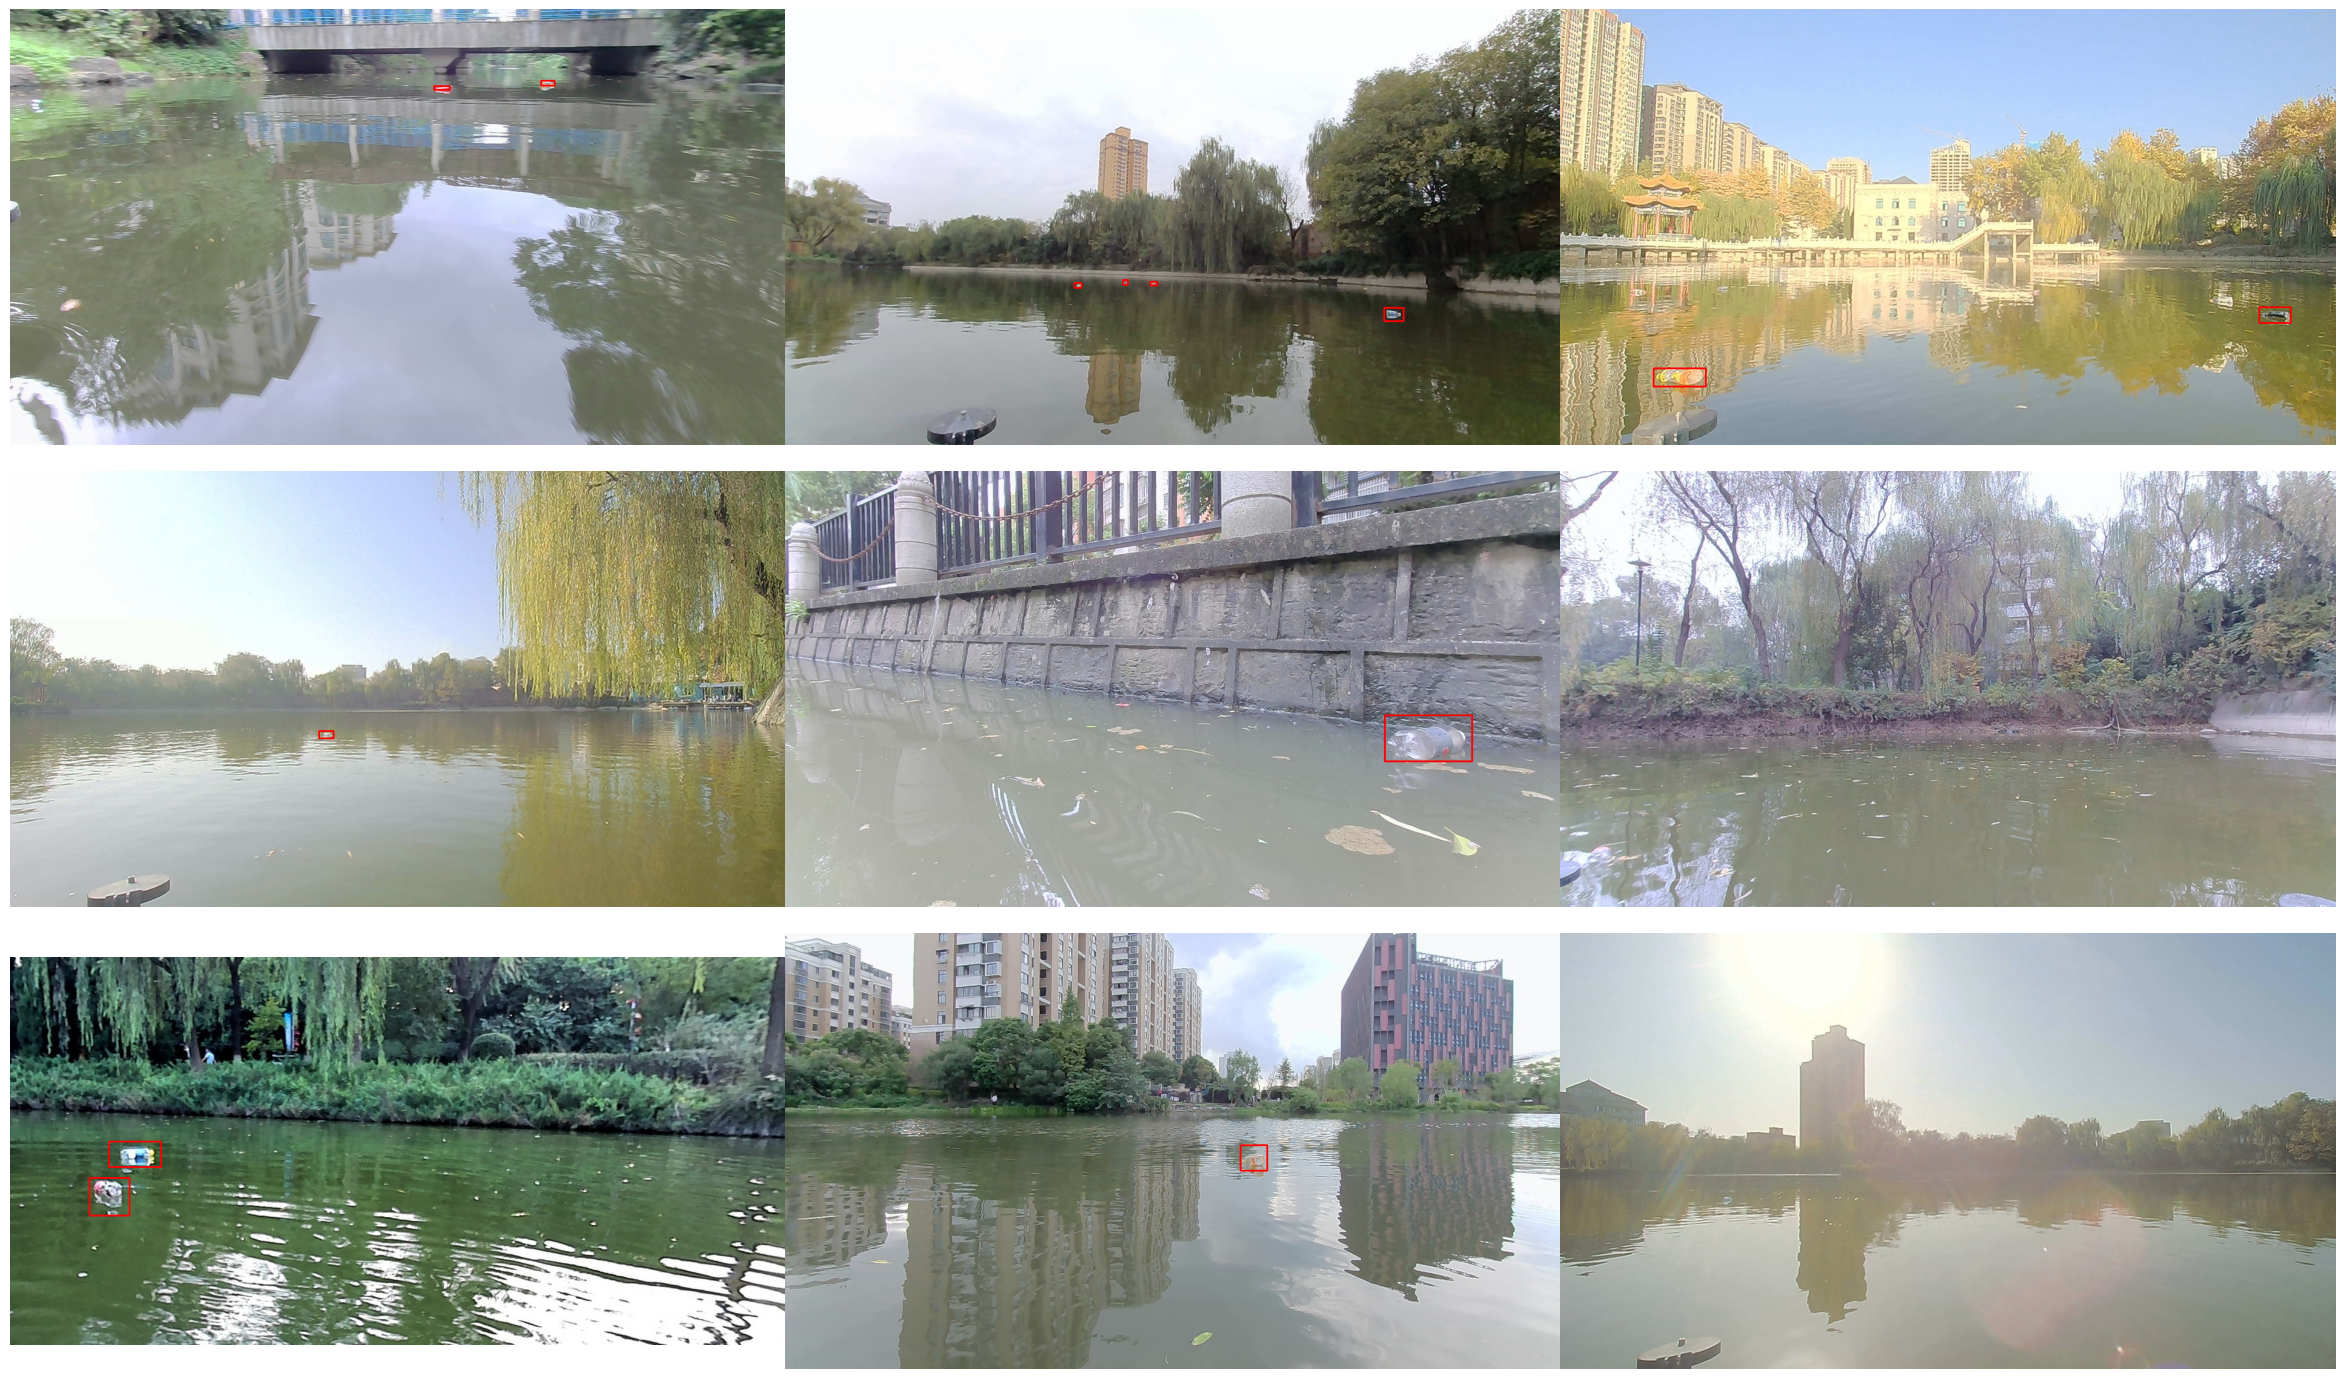

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Generate sample image data
draw_samples = dataset_data['train'][:9]
image_list = draw_samples['image']
bb_list = draw_samples['litter']

# Create the subplot grid
fig, axes = plt.subplots(3, 3, figsize=(30, 18))

# Plot the images
for i, ax in enumerate(axes.flat):
    img = np.asarray(image_list[i])
    width = img.shape[1]
    height = img.shape[0]
    bb_data = bb_list[i]
    for j in bb_list[i]['bbox']:
        x1, y1, w, h = j
        w = int(width * w)//2
        h = int(height * h)//2
        x1 = int(width * x1)
        y1 = int(height * y1)
        
        cv2.rectangle(img, (x1 - w, y1 - h), (x1 + w, y1 + h), (255,0,0), 2)

    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

# Show the plot
plt.show()

The images are of good quality and the plastics are in different positions and distances. This is a good dataset to work with.

## Upload dataset to bucket
Now we have our dataset ready to begin the work in OCI. 

We'll need to upload the images to a bucket so we can start work there. 

**There is something really important that I did not mention before, there lots of problems related with the mime-type of the images that the data-labeling service is not able to process, that's why I took my time before, to check that all the images had their correct mime-type. Making sure about that, is going to save you a lot of headaches.**


Change the next variables acording with your configuration.

- **OCI config file:** This file is created once you authenticate using the OCI cli. Change this value according with your enviroment.
- **A comparment OCID:** Where all the resources are going to be created. Copy and paste a OCID from your tenant.

In [6]:
OCI_CONFIG = '~/.oci/config'
COMPARMENT_OCID = '<PUT YOUR COMPARMENT OCID>'
BUCKET_NAME='{}-dataset-bucket'.format(dataset_label)

DATASET_NAME='{}-dataset'.format(dataset_label)
VISION_PROJECT_NAME='{}-project'.format(dataset_label)
VISION_MODEL_NAME='{}-model'.format(dataset_label)

config = oci.config.from_file(OCI_CONFIG)

Create the bucket to upload the dataset

In [7]:
from oci.object_storage import ObjectStorageClient
from oci.object_storage.models import CreateBucketDetails

# Object storage client
object_storage_client = ObjectStorageClient(config)
OBJECT_STORAGE_NAMESPACE = object_storage_client.get_namespace().data

# Request model
create_bucket_details = CreateBucketDetails(name=BUCKET_NAME, compartment_id=COMPARMENT_OCID, public_access_type=CreateBucketDetails.PUBLIC_ACCESS_TYPE_OBJECT_READ)

# Service call to create bucket
response_create_bucket = object_storage_client.create_bucket(namespace_name=OBJECT_STORAGE_NAMESPACE, create_bucket_details=create_bucket_details)

bucket_ocid = response_create_bucket.data.compartment_id


Now upload individually the images. If you had the same mime-type for all the images, is faster to use the bulk upload method.

In [8]:
def upload_file(file, mime_type):
    with open(file, "rb") as image:
        image_content = image.read()
    
    # Service call to upload individual file
    object_storage_client.put_object(namespace_name=OBJECT_STORAGE_NAMESPACE,
                                     bucket_name=BUCKET_NAME,
                                     object_name=file,
                                     put_object_body=image_content,
                                     content_length=len(image_content),
                                     content_type=mime_type)


for image in dataset.keys():
    upload_file(data_folder + '/' + image, 'image/jpeg')

Next cell is optional but is recommended as fail-safe to make sure that all the images on the bucket has the correct mime-type.

If in the response you find a mime-type not corresponding to an image, check your dataset.

In [9]:
# Service call to get the list of objects in bucket
list_files = object_storage_client.list_objects(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME)

mime_types = {}
# Get the details of every image to check their mime-type
for item in list_files.data.objects:
    res = object_storage_client.head_object(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME, object_name=item.name)
    mime_types[item.name] = res.headers['Content-Type']

print(set(mime_types.values()))

{'image/jpeg'}


## Create dataset in OCI

Now we are ready to create the dataset. (it will take 5 minutes, to create all the records of the images)

In [10]:
from oci.data_labeling_service import DataLabelingManagementClient, DataLabelingManagementClientCompositeOperations
from oci.data_labeling_service.models import CreateDatasetDetails, ImageDatasetFormatDetails, \
    ObjectStorageSourceDetails, InitialRecordGenerationConfiguration, Label, LabelSet, AnnotationFormat, GenerateDatasetRecordsDetails

# Data labeling clients
data_labeling_management_client = DataLabelingManagementClient(config)
data_labeling_composite_ops = DataLabelingManagementClientCompositeOperations(data_labeling_management_client)


# Request param with object storage detail
dataset_source_details = ObjectStorageSourceDetails(source_type='OBJECT_STORAGE', namespace=OBJECT_STORAGE_NAMESPACE, bucket=BUCKET_NAME)
dataset_format_details = ImageDatasetFormatDetails()
dataset_format_details.format_type = 'IMAGE'

initial_record_generation_configuration = InitialRecordGenerationConfiguration()
initial_record_generation_configuration.limit = 5000

label_set = LabelSet()
label_set.items = []

# Add all the labels used in dataset
for category in [dataset_label]:
    label = Label()
    label.name = category
    label_set.items.append(label)

# Request param to create dataset
create_dataset_details = CreateDatasetDetails(display_name=DATASET_NAME, description=DATASET_NAME,
                                              compartment_id=COMPARMENT_OCID,
                                              labeling_instructions='Labeling instructions',
                                              annotation_format='BOUNDING_BOX',
                                              label_set=label_set,
                                              dataset_source_details=dataset_source_details,
                                              dataset_format_details=dataset_format_details,
                                              initial_record_generation_configuration=initial_record_generation_configuration)

# Service call to create (and wait) for the dataset
data_label_response = data_labeling_composite_ops.create_dataset_and_wait_for_state(create_dataset_details=create_dataset_details, wait_for_states=['SUCCEEDED', 'FAILED'])

dataset_ocid = data_label_response.data.resources[0].identifier

generate_dataset_records_details = GenerateDatasetRecordsDetails(limit=1000)

data_labeling_composite_ops.generate_dataset_records_and_wait_for_state(dataset_ocid, generate_dataset_records_details)


The dataset was created, and now is time to label each image using our dataset.


In [11]:
from oci.data_labeling_service_dataplane import DataLabelingClient
from oci.data_labeling_service_dataplane.models import CreateRecordDetails, RecordMetadata, CreateObjectStorageSourceDetails, \
    CreateAnnotationDetails, GenericEntity, Label, ImageObjectSelectionEntity, BoundingPolygon, NormalizedVertex

# Data labeling client
data_labeling_client = DataLabelingClient(config)

# Service call to get the current records
list_records = data_labeling_client.list_records(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000)

# Service call to get the current annotations
list_annotations = data_labeling_client.list_annotations(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000)

records = {}
for record_summary in list_records.data.items:
    records[record_summary.name] = record_summary.id

# In case that the list of records request has more items
while list_records.has_next_page:
    list_records = data_labeling_client.list_records(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000, page=list_records.next_page)
    for record_summary in list_records.data.items:
        records[record_summary.name] = record_summary.id


for img_path in dataset.keys():
    record_id = records[data_folder + '/' + img_path]

    entities = []
    if len(dataset[img_path]) > 0:
        for bbox in dataset[img_path]:
    
            label_set = []
            label = Label()
            label.label = dataset_label
            label_set.append(label)
    
            vertex = [NormalizedVertex(x=bbox[0]['x'], y=bbox[0]['y']), NormalizedVertex(x=bbox[1]['x'], y=bbox[1]['y']),
                     NormalizedVertex(x=bbox[2]['x'], y=bbox[2]['y']), NormalizedVertex(x=bbox[3]['x'], y=bbox[3]['y'])]
            
            polygon = BoundingPolygon(normalized_vertices =vertex)
            
            image_entity = ImageObjectSelectionEntity(entity_type=ImageObjectSelectionEntity.ENTITY_TYPE_IMAGEOBJECTSELECTION,
                                                     labels=label_set, bounding_polygon=polygon)
            entities.append(image_entity)
            
        create_annotation_details = CreateAnnotationDetails(compartment_id=COMPARMENT_OCID,
                                                                record_id=record_id,
                                                                entities=entities)
        
        data_labeling_client.create_annotation(create_annotation_details)


## Create vision project

The dataset should be ready to create the vision project and the model for training.

In [14]:
from oci.ai_vision import AIServiceVisionClient, AIServiceVisionClientCompositeOperations
from oci.ai_vision.models import DataScienceLabelingDataset, CreateProjectDetails, CreateModelDetails

# Ai vision clients
ai_vision_client = AIServiceVisionClient(config)
ai_vision_composite_ops = AIServiceVisionClientCompositeOperations(ai_vision_client)

# Request model to create vision project
create_project_details = CreateProjectDetails(display_name=VISION_PROJECT_NAME, compartment_id=COMPARMENT_OCID)

# Service call to create 
project_response = ai_vision_composite_ops.create_project_and_wait_for_state(create_project_details)
project_id = project_response.data.id


The next step is to train the model, using the previous dataset created. (**it should take around 1 hours**)

In [15]:
# Request model to create model 
training_dataset = DataScienceLabelingDataset(dataset_id=dataset_ocid, dataset_type='DATA_SCIENCE_LABELING')

create_model_details = CreateModelDetails(display_name=VISION_MODEL_NAME, project_id=project_id, compartment_id=COMPARMENT_OCID, 
    training_dataset=training_dataset, max_training_duration_in_hours=0.5, model_type='OBJECT_DETECTION')

# Service call to create model
model_response = ai_vision_client.create_model(create_model_details)
model_id = model_response.data.id

## Testing the model
To test the model we call the analyze image service, but sending the identifier of our created model.


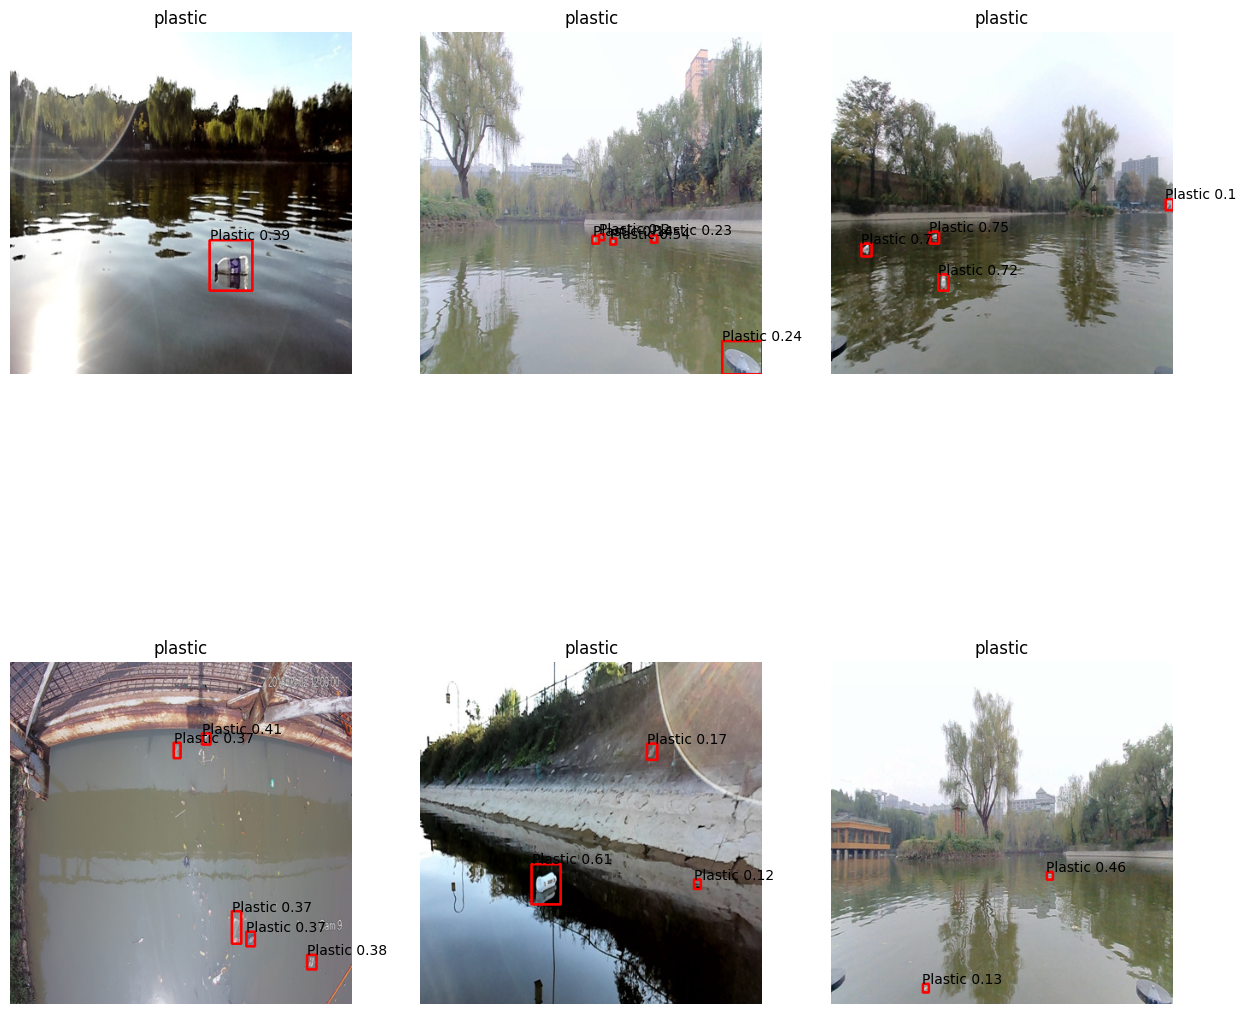

In [16]:
import base64
from oci.ai_vision.models import AnalyzeImageDetails, ImageObjectDetectionFeature, InlineImageDetails
from PIL import Image

# Method to call the trained model
def analize_image(image_path, model_id):

    with open(image_path, "rb") as image_file:
        image_encoded = base64.b64encode(image_file.read())

    image_details = InlineImageDetails()
    image_details.data = image_encoded.decode('utf-8')

    image_object_detection_feature = ImageObjectDetectionFeature(model_id=model_id)
    analyze_image_details = AnalyzeImageDetails(image=image_details, features=[image_object_detection_feature])

    analysis_response = ai_vision_client.analyze_image(analyze_image_details=analyze_image_details)

    return analysis_response.data
    
# Check of two bounding boxes intersect.
def intersects(rect1, rect2):
    return not (rect1[2].x <  rect2[0].x  or rect1[0].x > rect2[2].x or rect1[2].y  <  rect1[0].y or rect1[0].y > rect2[2].y)

# Format decimal to two positions
def two_decimal(num):
    return (int)(num*100)/100

# Create groups of the detectec objects to only draw one single bounding box
def group_boundind_box(res):
    groups = []
    for image_objects in res.image_objects:
        flag = False
        for i, g in enumerate(groups):
            if intersects(image_objects.bounding_polygon.normalized_vertices, g['vertices']):
                flag = True
                groups[i]['values'].append({'name' : image_objects.name, 'confidence': image_objects.confidence})
                groups[i]['labels'] = groups[i]['labels'] + ' | ' +  image_objects.name + ' ' + str(two_decimal(image_objects.confidence))
                break
        if not flag:
            groups.append({'values' : [{'name' : image_objects.name, 'confidence': image_objects.confidence}], 'vertices' : image_objects.bounding_polygon.normalized_vertices, 'labels': image_objects.name + ' ' + str(two_decimal(image_objects.confidence))})
    
    return groups

# Reshape functions so image can fit the screen
def img_reshape(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((400,400))
    img = np.asarray(img)
    return img
    

rows = len(labels) + 1
cols = 3

# Showing a grid of images as test
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))


for i, label in enumerate([dataset_label, dataset_label]):
    for j in range(cols):
        
        image = random.choice(os.listdir(data_folder + '/' + label + '/'))
        
        img_path = 'data/' + label + '/' + image
        groups = group_boundind_box(analize_image(img_path, model_id))
        r_image = img_reshape(img_path)
        w_image = r_image.shape[0]
        h_image = r_image.shape[1]
        
        for g in groups:
            x1 = int(g['vertices'][0].x * w_image)
            y1 = int(g['vertices'][0].y * h_image)
            x2 = g['vertices'][2].x * w_image
            y2 = g['vertices'][2].y * h_image
            w = int(x2 - x1)
            h = int(y2 - y1)
            
            cv2.rectangle(r_image, (x1, y1), (x1 + w, y1 + h), (255,0,0), 2)
            axes[i, j].text(x1, y1, g['labels'])

        
        axes[i, j].imshow(r_image)
        axes[i, j].set_axis_off()
        axes[i, j].set_title(label)


Well is better than expected. It seems that has problems detecting the 'Shaishe' date, but the other ones are not bad.

For me they look too similiar in to now exactly the type.

## Delete OCI resources
Lets clean everything

In [76]:
# Delete vision model
ai_vision_composite_ops.delete_model_and_wait_for_state(model_id=model_id, wait_for_states=['SUCCEEDED', 'FAILED'])

# Delete vision project
ai_vision_composite_ops.delete_project_and_wait_for_state(project_id=project_id, wait_for_states=['SUCCEEDED', 'FAILED'])

# Delete dataset
data_labeling_composite_ops.delete_dataset_and_wait_for_state(dataset_id=dataset_ocid, wait_for_states=['SUCCEEDED', 'FAILED'])

# List objects in bucket
list_files = object_storage_client.list_objects(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME)

# Delete every image in bucket
for item in list_files.data.objects:
    object_storage_client.delete_object(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME, object_name=item.name)

# Delete the entire bucket
bucket_delete_response = object_storage_client.delete_bucket(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME)